In [265]:
# Import important library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Read the input file and check the data dimension

In [266]:
# You can access from https://www.kaggle.com/uciml/german-credit
#Read input file and understand the data
# "default" is my dependent variable
df = pd.read_csv("german_credit.csv")
X = df.iloc[:, df.columns != 'default']
Y = df.iloc[:, df.columns == 'default']

### Q1 Randomly select 50% data for this use case( 1 Marks)
###### Hint: Use train_test_split

In [267]:
train_size=0.50
test_size = 0.50 # taking 70:30 training and test set
seed = 7 # Random number seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_size, test_size=test_size, random_state=seed)

In [268]:
# Lets build a Ensemble model but need to modify the dataset first

### Q2.Prepare the model data by converting non-numeric to dummy ( 1 Marks)
##### Hint: Use get_dummies

In [269]:
# Print Shape of model data
print("X Shape: ", X_train.shape)
print("Y Shape: ", y_train.shape)

X Shape:  (500, 20)
Y Shape:  (500, 1)


In [270]:
for col in X_train.columns:
    if(X_train[col].dtype == object):
        dummies = pd.get_dummies(X_train[col])
        X_train[dummies.columns] = dummies
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 262 to 175
Data columns (total 72 columns):
account_check_status                                                500 non-null object
duration_in_month                                                   500 non-null int64
credit_history                                                      500 non-null object
purpose                                                             500 non-null object
credit_amount                                                       500 non-null int64
savings                                                             500 non-null object
present_emp_since                                                   500 non-null object
installment_as_income_perc                                          500 non-null int64
personal_status_sex                                                 500 non-null object
other_debtors                                                       500 non-null object
present_res_sinc

### Check for highly correlated variables but don't required any treatment for this use case

In [271]:
#Highly Correlated Variables will be those with correlation above 0.3
corrTable = X_train.corr()
corr_triu = corrTable.where(~np.tril(np.ones(corrTable.shape)).astype(np.bool))
corr_triu = corr_triu.stack()
corr_triu.index.names = ['Col1', 'Col2']
corr_triu = corr_triu[corr_triu > 0.3].to_frame()
corr_triu

0
Col1                                               Col2                                                        
duration_in_month                                  credit_amount                                       0.669686
credit_amount                                      unknown / no property                               0.307632
                                                   management/ self-employed/ highly qualified emp...  0.334242
present_res_since                                  .. >= 7 years                                       0.319913
age                                                .. >= 7 years                                       0.352581
credits_this_bank                                  critical account/ other credits existing (not a...  0.540030
people_under_maintenance                           male : single                                       0.300646
all credits at this bank paid back duly            bank                                                0.353811
unemployed                                         unemployed/ unskilled - non-resident                0.550908
unknown / no property                              for free                                            0.808156
management/ self-employed/ highly qualified emp... yes, registered under the customers name            0.414907

### Drop the original variables which are converted to dummy

In [272]:
for col in X_train.columns:
    if(X_train[col].dtype == object):
        X_train.drop(columns = col, axis = 1, inplace = True)
print("NaN Values (if any): ", X_train[X_train.isna().any(axis=1)].shape)
print("Null Values (if any): ", X_train[X_train.isnull().any(axis=1)].shape)
#No Null

NaN Values (if any):  (0, 59)
Null Values (if any):  (0, 59)


### Q3 Split Train/Test data 70:30 ratio( 1 Marks)
##### Hint:from sklearn.model_selection import train_test_split

In [273]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_train, y_train, train_size = 0.7, test_size = 0.3, random_state=seed)

### Q4 Build Random Forest Model( 1 Marks)
#### Hint:from sklearn.ensemble import RandomForestClassifier using n_jobs=2,n_estimators=500,criterion="entropy",random_state=9999

In [274]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_jobs = 2, n_estimators = 500, criterion = "entropy", random_state=9999)
rfcl = rfcl.fit(X_train_final, y_train_final)
rfcl_prediction = rfcl.predict(X_test_final)

### Q5 Calculate Confusion Matrix and Accuracy score (1 Marks)
##### Hint: Use confusion_matrix and accuracy_score

In [275]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, auc, roc_curve
confusion_matrix(y_test_final, rfcl_prediction)

array([[95,  8],
       [32, 15]])

In [276]:
accuracy_score(y_test_final, rfcl_prediction)

0.7333333333333333

### Q6 Show the list of the features importance( 1 Marks)

In [277]:
print("Number of Features: ", rfcl.feature_importances_.size)
feature_importance_list = pd.DataFrame(rfcl.feature_importances_)
feature_importance_list = feature_importance_list.T
feature_importance_list.columns = X_train_final.columns
feature_importance_list

Number of Features:  59


,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,0 <= ... < 200 DM,< 0 DM,>= 200 DM / salary assignments for at least 1 year,...,for free,own,rent,management/ self-employed/ highly qualified employee/ officer,skilled employee / official,unemployed/ unskilled - non-resident,unskilled - resident,"yes, registered under the customers name",no,yes
0,0.08718,0.114664,0.035242,0.033788,0.073983,0.018826,0.016358,0.017301,0.024839,0.009382,...,0.007677,0.015864,0.012451,0.009979,0.016833,0.001877,0.012547,0.01325,0.001644,0.001443


### Q7 K-fold cross-validation( 2 Marks)
##### k-fold cross validation( without stratification)
##### Usually k is set as 10-20 in practical settings, depends on data set size

In [278]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [279]:
# Use below values
num_folds = 10
seed = 77
k_fold = KFold(n_splits = num_folds,shuffle = True, random_state = seed)

In [280]:
#Validate the Random Forest model build above using k fold

In [281]:
score_array = cross_val_score(rfcl, X_train_final, y_train_final, cv = k_fold)
print(score_array)

[0.77142857 0.68571429 0.68571429 0.71428571 0.65714286 0.77142857
 0.77142857 0.71428571 0.77142857 0.85714286]


In [282]:
#Calculate Mean score

In [283]:
avg_score = np.mean(score_array)
print("Average Score: ", avg_score)

Average Score:  0.74


In [284]:
# Calculate score standard deviation using std()

In [285]:
print("Standard Score Deviation: ", score_array.std())
X_train.head()

Standard Score Deviation:  0.05635166549518862


,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,0 <= ... < 200 DM,< 0 DM,>= 200 DM / salary assignments for at least 1 year,...,for free,own,rent,management/ self-employed/ highly qualified employee/ officer,skilled employee / official,unemployed/ unskilled - non-resident,unskilled - resident,"yes, registered under the customers name",no,yes
262,18,5302,2,4,36,3,1,0,1,0,...,1,0,0,1,0,0,0,1,0,1
457,12,3386,3,4,35,1,1,0,1,0,...,1,0,0,0,1,0,0,1,0,1
82,18,1568,3,4,24,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
563,36,12389,1,4,37,1,1,1,0,0,...,1,0,0,0,1,0,0,1,0,1
407,15,1053,4,2,27,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0


# Q8 Print the confusion matrix( 1 Marks)

In [286]:
i = 1
for train_index, test_index in k_fold.split(X_train, y_train):
    print("Iteration {0}".format(i))
    X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]
    y_pred_k=rfcl.predict(X_test_k)
    print("Confusion Matrix: \n", confusion_matrix(y_test_k, y_pred_k))
    i = i + 1

Iteration 1
Confusion Matrix: 
 [[34  1]
 [ 4 11]]
Iteration 2
Confusion Matrix: 
 [[35  0]
 [ 2 13]]
Iteration 3
Confusion Matrix: 
 [[32  1]
 [ 5 12]]
Iteration 4
Confusion Matrix: 
 [[36  1]
 [ 5  8]]
Iteration 5
Confusion Matrix: 
 [[35  0]
 [ 1 14]]
Iteration 6
Confusion Matrix: 
 [[31  0]
 [ 1 18]]
Iteration 7
Confusion Matrix: 
 [[38  1]
 [ 3  8]]
Iteration 8
Confusion Matrix: 
 [[32  2]
 [ 5 11]]
Iteration 9
Confusion Matrix: 
 [[33  0]
 [ 2 15]]
Iteration 10
Confusion Matrix: 
 [[29  2]
 [ 4 15]]


# Q9.Classification accuracy: 
percentage of correct predictions and Calculate sensitivity (or True Positive Rate or Recall) and Precision.
( 1 Marks)

In [287]:
i = 1
for train_index, test_index in k_fold.split(X_train, y_train):
    print("Iteration {0}".format(i))
    X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]
    y_pred_k=rfcl.predict(X_test_k)
    print("Accuracy Score: ", accuracy_score(y_test_k, y_pred_k))
    print("Recall (Sensitivity/True Positive Rate): ", recall_score(y_test_k, y_pred_k))
    print("Precision: ", precision_score(y_test_k, y_pred_k))
    i = i + 1

Iteration 1
Accuracy Score:  0.9
Recall (Sensitivity/True Positive Rate):  0.7333333333333333
Precision:  0.9166666666666666
Iteration 2
Accuracy Score:  0.96
Recall (Sensitivity/True Positive Rate):  0.8666666666666667
Precision:  1.0
Iteration 3
Accuracy Score:  0.88
Recall (Sensitivity/True Positive Rate):  0.7058823529411765
Precision:  0.9230769230769231
Iteration 4
Accuracy Score:  0.88
Recall (Sensitivity/True Positive Rate):  0.6153846153846154
Precision:  0.8888888888888888
Iteration 5
Accuracy Score:  0.98
Recall (Sensitivity/True Positive Rate):  0.9333333333333333
Precision:  1.0
Iteration 6
Accuracy Score:  0.98
Recall (Sensitivity/True Positive Rate):  0.9473684210526315
Precision:  1.0
Iteration 7
Accuracy Score:  0.92
Recall (Sensitivity/True Positive Rate):  0.7272727272727273
Precision:  0.8888888888888888
Iteration 8
Accuracy Score:  0.86
Recall (Sensitivity/True Positive Rate):  0.6875
Precision:  0.8461538461538461
Iteration 9
Accuracy Score:  0.96
Recall (Sensitiv

# Q10.Plot Receiver Operating Characteristic (ROC) Curves( 1 Marks)

In [288]:
#Hint: Use roc_curve

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


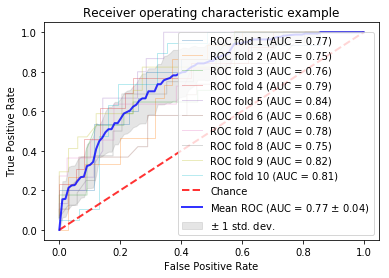

In [294]:
from scipy import interp
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
arr_prob = []

i = 1
for train_index, test_index in k_fold.split(X_train, y_train):
    print("Iteration {0}".format(i))
    X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]
    probas_ = rfcl.fit(X_train_k, y_train_k).predict_proba(X_test_k)
    arr_prob.append(probas_)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test_k, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ROC curve can help you to choose a threshold that balances sensitivity and specificity in a way that makes sense for your particular context

# Q11. Calculate AUC(the percentage of the ROC plot that is underneath the curve) - optional

In [295]:
arr_prob = []
i = 1
for train_index, test_index in k_fold.split(X_train, y_train):
    print("Iteration {0}".format(i))
    X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]
    probas_ = rfcl.fit(X_train_k, y_train_k).predict_proba(X_test_k)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_k, probas_[:, 1])
    print("AUC: \t", auc(false_positive_rate, true_positive_rate))
    i = i + 1

Iteration 1
AUC: 	 0.7657142857142858
Iteration 2
AUC: 	 0.7523809523809524
Iteration 3
AUC: 	 0.7566844919786097
Iteration 4
AUC: 	 0.7920997920997921
Iteration 5
AUC: 	 0.839047619047619
Iteration 6
AUC: 	 0.6833616298811545
Iteration 7
AUC: 	 0.7797202797202798
Iteration 8
AUC: 	 0.7518382352941178
Iteration 9
AUC: 	 0.8172905525846702
Iteration 10
AUC: 	 0.8081494057724957


### Bootstrapping ( Bonus)
##### Given a dataset of size n, a bootstrap sample is created by sampling n instances uniformly from the data (with/without replacement)
##### Create a model with each bootstrap sample and validate it with the test set
##### Final result is calculated by averaging the accuracy of models

In [296]:
# Number of iterations for bootstrapping
bootstrap_iteration = 10
accuracy = []

In [297]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

for i in range(bootstrap_iteration):
    X_, y_ = resample(X_train_final, y_train_final)
    rfcl.fit(X_, y_)
    y_pred = rfcl.predict(X_test_final)
    
    acc = accuracy_score(y_pred, y_test_final)
    accuracy.append(acc)

In [298]:
accuracy = np.array(accuracy)
print('Accuracy Score')
print('Average: ', accuracy.mean())
print('Standard deviation: ', accuracy.std())

Accuracy Score
Average:  0.7313333333333334
Standard deviation:  0.01579029237643601
